In [1]:
import operator
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


df = pd.read_csv('bike_sharing_registred_counts_ts.csv')
data = series_to_supervised(df, 1, 5)

data.rename(
    columns={"var1(t-1)": "lag5", "var1(t)": "lag4", "var1(t+1)": "lag3", "var1(t+2)": "lag2", "var1(t+3)": "lag1",
             "var1(t+4)": "target"}, inplace=True)

In [3]:
print(df)

        x
0     341
1     290
2     316
3     304
4     292
...   ...
2688    6
2689    4
2690   38
2691  136
2692  387

[2693 rows x 1 columns]


In [4]:
print(data)

       lag5  lag4   lag3   lag2   lag1  target
1     341.0   290  316.0  304.0  292.0   193.0
2     290.0   316  304.0  292.0  193.0   178.0
3     316.0   304  292.0  193.0  178.0   129.0
4     304.0   292  193.0  178.0  129.0   102.0
5     292.0   193  178.0  129.0  102.0   128.0
...     ...   ...    ...    ...    ...     ...
2684   85.0    44   18.0   11.0    9.0     6.0
2685   44.0    18   11.0    9.0    6.0     4.0
2686   18.0    11    9.0    6.0    4.0    38.0
2687   11.0     9    6.0    4.0   38.0   136.0
2688    9.0     6    4.0   38.0  136.0   387.0

[2688 rows x 6 columns]


In [5]:
target = data.target
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]

In [6]:
print(data)

      target   lag5  lag4   lag3   lag2   lag1
1      193.0  341.0   290  316.0  304.0  292.0
2      178.0  290.0   316  304.0  292.0  193.0
3      129.0  316.0   304  292.0  193.0  178.0
4      102.0  304.0   292  193.0  178.0  129.0
5      128.0  292.0   193  178.0  129.0  102.0
...      ...    ...   ...    ...    ...    ...
2684     6.0   85.0    44   18.0   11.0    9.0
2685     4.0   44.0    18   11.0    9.0    6.0
2686    38.0   18.0    11    9.0    6.0    4.0
2687   136.0   11.0     9    6.0    4.0   38.0
2688   387.0    9.0     6    4.0   38.0  136.0

[2688 rows x 6 columns]


In [7]:
train_ts = data.loc[0:2000, 'target']
train_ts = pd.DataFrame(train_ts)
test_ts = data.loc[2001:2688, 'target']
test_ts = pd.DataFrame(test_ts)
train_reg = data.loc[0:2000, :]
test_reg = data.loc[2001:2688, :]
data_train = train_reg
data_test = test_reg

n = len(data_train)
val_length = 10
H = 10

lastTenRows = n - val_length
data_val = data_train.loc[lastTenRows + 1:n, :]

data_train_n = data_train.loc[1:lastTenRows, :]
X_data_train_n = data_train_n.drop('target', axis=1)
y_data_train_n = data_train_n['target']

# train models

In [8]:
from sklearn.svm import SVR
import subprocess
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from numpy import *
import scipy as sp
from pandas import *
import array
from rpy2.robjects import IntVector, Formula
# import pandas.rpy.common as com

In [9]:
def train_models():
    train_reg = data_train
    train_ts = data_train_n.loc[ :, 'target']
    train_ts = pd.DataFrame(train_ts)
    train_ts.columns=['ts']

    X_train_reg = train_reg.drop('target', axis=1)
    y_train_reg = train_reg['target']

    fmla = Formula('target~.')

    # ksvm models
    kernlab = importr('kernlab')
    prebModel = 'prob.model=TRUE'

    # svr_rbf = SVR(kernel='rbf', gamma='auto')
    # svr_rbf.fit(X_train_reg, y_train_reg)

    svr_rbf = kernlab.ksvm(fmla, data=train_reg, type="eps-svr", kernel="rbfdot", kpar="automatic", prob_model=True)

    svr_pol = kernlab.ksvm(fmla, data=train_reg, type="eps-svr", kernel="polydot", kpar="automatic", prob_model=True)

    svr_ln = kernlab.ksvm(fmla, data=train_reg, type="eps-svr", kernel="vanilladot", kpar="automatic", prob_model=True)

    svr_lap = kernlab.ksvm(fmla, data=train_reg, type="eps-svr", kernel="laplacedot", kpar="automatic", prob_model=True)

    # mars models
    mda = importr('mda')
    mars_1_7 = mda.mars(x=X_train_reg, y=y_train_reg, degree=1, nk=7)

    mars_1_15 = mda.mars(x=X_train_reg, y=y_train_reg, degree=1, nk=15)

    mars_3_7 = mda.mars(x=X_train_reg, y=y_train_reg, degree=3, nk=7)

    mars_3_15 = mda.mars(x=X_train_reg, y=y_train_reg, degree=3, nk=15)

    # gbm model
    gbm = importr('gbm')
    gbm_10 = gbm.gbm(fmla, data=train_reg, n_trees=10)

    # RandomForest models
    rf = importr('randomForest')
    rf_100 = rf.randomForest(fmla, data=train_reg, ntree=100)

    rf_250 = rf.randomForest(fmla, data=train_reg, ntree=250)

    rf_500 = rf.randomForest(fmla, data=train_reg, ntree=500)

    # ppr models
    stats = importr('stats')
    ppr_2 = stats.ppr(fmla, data=train_reg, nterms=2, max_terms=5)

    ppr_5 = stats.ppr(fmla, data=train_reg, nterms=5, max_terms=5)

    # monmlp model
    monmlpp = importr('monmlp')
    rmatrix = ro.r['as.matrix']
    X = rmatrix(X_train_reg)
    y = rmatrix(y_train_reg)

    mlp_3 = monmlpp.monmlp_fit(x=X, y=y, hidden1=3, n_ensemble=1, bag=False, silent=True)

    mlp_5 = monmlpp.monmlp_fit(x=X, y=y, hidden1=5, n_ensemble=1, bag=False, silent=True)

    mlp_7 = monmlpp.monmlp_fit(x=X, y=y, hidden1=7, n_ensemble=1, bag=False, silent=True)

    mlp_10 = monmlpp.monmlp_fit(x=X, y=y, hidden1=10, n_ensemble=1, bag=False, silent=True)

    mlp_15 = monmlpp.monmlp_fit(x=X, y=y, hidden1=15, n_ensemble=1, bag=False, silent=True)

    mlp_25 = monmlpp.monmlp_fit(x=X, y=y, hidden1=25, n_ensemble=1, bag=False, silent=True)


    # guassian process model
    gp_rbf = kernlab.gausspr(fmla, data=train_reg, type='regression', kernel='rbfdot', kpar='automatic', prob_model=True)

    gp_pol = kernlab.gausspr(fmla, data=train_reg, type='regression', kernel='polydot', kpar='automatic', prob_model=True)

    gp_ln = kernlab.gausspr(fmla, data=train_reg, type='regression', kernel='vanilladot', kpar='automatic', prob_model=True)

    gp_lap = kernlab.gausspr(fmla, data=train_reg, type='regression', kernel='laplacedot', kpar='automatic', prob_model=True)

    # plsr models
    pls = importr('pls')
    pls_sim = pls.plsr(fmla, data=train_reg, validation='CV', method='simpls')

    pls_ker = pls.plsr(fmla, data=train_reg, validation='CV', method='widekernelpls')

    #pcr model
    pcmr = pls.pcr(fmla, data=train_reg)

    # rpart model
    rpart = importr('rpart')
    dt = rpart.rpart(fmla, method='anova', data=train_reg)

    # gbm 5 model
    gbm_5 = gbm.gbm(fmla, data=train_reg, n_trees=5)

    output_model = [pls_sim, pls_ker, pcmr, gbm_10, rf_100, rf_250, rf_500, svr_lap, svr_pol, svr_rbf, svr_ln, gp_lap, gp_pol, gp_rbf, gp_ln, mlp_3, mlp_5, mlp_7, mlp_10, mlp_15, mlp_25, ppr_2, ppr_5, mars_1_7, mars_1_15, mars_3_7, mars_3_15, dt, gbm_5]

    return output_model

In [10]:
models = train_models()

In [11]:
def predict_models():
    val_reg = data_test
    val_ts = val_reg.loc[ :, 'target']
    val_ts = pd.DataFrame(val_ts)
    val_ts.columns=['ts']

    from datetime import datetime

    st = datetime.now()

    predict = ro.r['predict']

    pred_pls_sim = predict(models[0], val_reg, type='response', ncomp=1)
    rvector = ro.r['as.vector']
    pred_pls_sim = rvector(pred_pls_sim)
    np.asarray(pred_pls_sim)
    pred_pls_sim_list=[]
    for x in pred_pls_sim:
        pred_pls_sim_list.append(x)

    pred_pls_ker = rvector(predict(models[1], val_reg, type='response', ncomp=1))
    np.asarray(pred_pls_ker)
    pred_pls_ker_list=[]
    for x in pred_pls_ker:
        pred_pls_ker_list.append(x)

    pred_pcmr = rvector(predict(models[2], val_reg, type='response', ncomp=1))
    np.asarray(pred_pcmr)
    pred_pcmr_list=[]
    for x in pred_pcmr:
        pred_pcmr_list.append(x)

    gbm = importr('gbm')
    n_trees='n.trees=10'
    pred_gbm_10 = rvector(predict(models[3], val_reg, n_trees, type='response'))
    np.asarray(pred_gbm_10)
    pred_gbm_10_list=[]
    for x in pred_gbm_10:
        pred_gbm_10_list.append(x)

    pred_rf_100 = rvector(predict(models[4], val_reg, type='response'))
    np.asarray(pred_rf_100)
    pred_rf_100_list=[]
    for x in pred_rf_100:
        pred_rf_100_list.append(x)

    pred_rf_250 = rvector(predict(models[5], val_reg, type='response'))
    np.asarray(pred_rf_250)
    pred_rf_250_list=[]
    for x in pred_rf_250:
        pred_rf_250_list.append(x)

    pred_rf_500 = rvector(predict(models[6], val_reg, type='response'))
    np.asarray(pred_rf_500)
    pred_rf_500_list=[]
    for x in pred_rf_500:
        pred_rf_500_list.append(x)

    pred_svr_lap = rvector(predict(models[7], val_reg, type='response'))
    np.asarray(pred_svr_lap)
    pred_svr_lap_list=[]
    for x in pred_svr_lap:
        pred_svr_lap_list.append(x)

    pred_svr_pol = rvector(predict(models[8], val_reg, type='response'))
    np.asarray(pred_svr_pol)
    pred_svr_pol_list=[]
    for x in pred_svr_pol:
        pred_svr_pol_list.append(x)

    pred_svr_rbf = rvector(predict(models[9], val_reg, type='response'))
    np.asarray(pred_svr_rbf)
    pred_svr_rbf_list=[]
    for x in pred_svr_rbf:
        pred_svr_rbf_list.append(x)

    pred_svr_ln = rvector(predict(models[10], val_reg, type='response'))
    np.asarray(pred_svr_ln)
    pred_svr_ln_list=[]
    for x in pred_svr_ln:
        pred_svr_ln_list.append(x)

    pred_gp_lap = rvector(predict(models[11], val_reg, type='response'))
    np.asarray(pred_gp_lap)
    pred_gp_lap_list=[]
    for x in pred_gp_lap:
        pred_gp_lap_list.append(x)

    pred_gp_pol = rvector(predict(models[12], val_reg, type='response'))
    np.asarray(pred_gp_pol)
    pred_gp_pol_list=[]
    for x in pred_gp_pol:
        pred_gp_pol_list.append(x)

    pred_gp_rbf = rvector(predict(models[13], val_reg, type='response'))
    np.asarray(pred_gp_rbf)
    pred_gp_rbf_list=[]
    for x in pred_gp_rbf:
        pred_gp_rbf_list.append(x)

    pred_gp_ln = rvector(predict(models[14], val_reg, type='response'))
    np.asarray(pred_gp_ln)
    pred_gp_ln_list=[]
    for x in pred_gp_ln:
        pred_gp_ln_list.append(x)

    rmatrix = ro.r['as.matrix']
    monmlpp = importr('monmlp')
    X_val_reg = rmatrix(val_reg.drop('target', axis=1))
    pred_mlp_3 = rvector(monmlpp.monmlp_predict(X_val_reg, models[15]))
    np.asarray(pred_mlp_3)
    pred_mlp_3_list=[]
    for x in pred_mlp_3:
        pred_mlp_3_list.append(x)

    pred_mlp_5 = rvector(monmlpp.monmlp_predict(X_val_reg, models[16]))
    np.asarray(pred_mlp_5)
    pred_mlp_5_list=[]
    for x in pred_mlp_5:
        pred_mlp_5_list.append(x)

    pred_mlp_7 = rvector(monmlpp.monmlp_predict(X_val_reg, models[17]))
    np.asarray(pred_mlp_7)
    pred_mlp_7_list=[]
    for x in pred_mlp_7:
        pred_mlp_7_list.append(x)

    pred_mlp_10 = rvector(monmlpp.monmlp_predict(X_val_reg, models[18]))
    np.asarray(pred_mlp_10)
    pred_mlp_10_list=[]
    for x in pred_mlp_10:
        pred_mlp_10_list.append(x)

    pred_mlp_15 = rvector(monmlpp.monmlp_predict(X_val_reg, models[19]))
    np.asarray(pred_mlp_15)
    pred_mlp_15_list=[]
    for x in pred_mlp_15:
        pred_mlp_15_list.append(x)

    pred_mlp_25 = rvector(monmlpp.monmlp_predict(X_val_reg, models[20]))
    np.asarray(pred_mlp_25)
    pred_mlp_25_list=[]
    for x in pred_mlp_25:
        pred_mlp_25_list.append(x)

    pred_ppr_2 = rvector(predict(models[21], val_reg, type='response'))
    np.asarray(pred_ppr_2)
    pred_ppr_2_list=[]
    for x in pred_ppr_2:
        pred_ppr_2_list.append(x)

    pred_ppr_5 = rvector(predict(models[22], val_reg, type='response'))
    np.asarray(pred_ppr_5)
    pred_ppr_5_list=[]
    for x in pred_ppr_5:
        pred_ppr_5_list.append(x)

    pred_mars_1_7 = rvector(predict(models[23], val_reg.drop('target', axis=1)))
    np.asarray(pred_mars_1_7)
    pred_mars_1_7_list=[]
    for x in pred_mars_1_7:
        pred_mars_1_7_list.append(x)

    pred_mars_1_15 = rvector(predict(models[24], val_reg.drop('target', axis=1)))
    np.asarray(pred_mars_1_15)
    pred_mars_1_15_list=[]
    for x in pred_mars_1_15:
        pred_mars_1_15_list.append(x)

    pred_mars_3_7 = rvector(predict(models[25], val_reg.drop('target', axis=1)))
    np.asarray(pred_mars_3_7)
    pred_mars_3_7_list=[]
    for x in pred_mars_3_7:
        pred_mars_3_7_list.append(x)

    pred_mars_3_15 = rvector(predict(models[26], val_reg.drop('target', axis=1)))
    np.asarray(pred_mars_3_15)
    pred_mars_3_15_list=[]
    for x in pred_mars_3_15:
        pred_mars_3_15_list.append(x)

    pred_dt = predict(models[27], val_reg)
    np.asarray(pred_dt)
    pred_dt_list=[]
    for x in pred_dt:
        pred_dt_list.append(x)

    n_trees_gbm_5='n.trees=5'
    pred_gbm_5 = rvector(predict(models[28], val_reg, n_trees_gbm_5, type='response'))
    np.array(pred_gbm_5)
    pred_gbm_5_list=[]
    for x in pred_gbm_5:
        pred_gbm_5_list.append(x)


    # output_m = pd.DataFrame(val_ts, pred_pls_sim, pred_pls_ker, pred_pcmr, pred_gbm_10, pred_rf_100, pred_rf_250, pred_rf_500, pred_svr_lap, pred_svr_pol, pred_svr_rbf, pred_svr_ln, pred_gp_lap, pred_gp_pol, pred_gp_rbf, pred_gp_ln, pred_mlp_3, pred_mlp_7, pred_mlp_5, pred_mlp_10, pred_mlp_15, pred_mlp_25, pred_ppr_2, pred_ppr_5, pred_mars_1_7, pred_mars_1_15, pred_mars_3_7, pred_mars_3_15, pred_dt, pred_gbm_5)

    # output_m = pd.DataFrame(np.array(val_ts, pred_pls_sim, pred_pls_ker, pred_pcmr, pred_gbm_10, 
                # pred_rf_100, pred_rf_250, pred_rf_500, pred_svr_lap, pred_svr_pol, pred_svr_rbf, 
                # pred_svr_ln, pred_gp_lap, pred_gp_pol, pred_gp_rbf, pred_gp_ln, pred_mlp_3, pred_mlp_7, 
                # pred_mlp_5, pred_mlp_10, pred_mlp_15, pred_mlp_25, pred_ppr_2, pred_ppr_5, pred_mars_1_7, 
                # pred_mars_1_15, pred_mars_3_7, pred_mars_3_15, pred_dt, pred_gbm_5))

    # output_m = pd.DataFrame(np.array([pred_pls_sim, pred_pls_ker, pred_gbm_10]))

    # d = {'val_ts':val_ts}

    #output_m = pd.DataFrame({'a':[pred_pls_sim]})

    index = val_ts.index
    val_ts = val_ts.values.tolist()
    from itertools import chain
    val_ts = list(chain.from_iterable(val_ts))

    output_m = pd.DataFrame({'val_ts':val_ts, 'pred_pls_sim': pred_pls_sim_list, 'pred_pls_ker': pred_pls_ker_list,
                            'pred_pcmr': pred_pcmr_list, 'pred_gbm_10': pred_gbm_10_list,
                            'pred_rf_100': pred_rf_100_list, 'pred_rf_250': pred_rf_250_list,
                            'pred_rf_500': pred_rf_500_list, 'pred_svr_lap': pred_svr_lap_list,
                            'pred_svr_pol': pred_svr_pol_list, 'pred_svr_rbf': pred_svr_rbf_list,
                            'pred_svr_ln': pred_svr_ln_list, 'pred_gp_lap': pred_gp_lap_list,
                            'pred_gp_pol': pred_gp_pol_list, 'pred_gp_rbf': pred_gp_rbf_list,
                            'pred_gp_ln': pred_gp_ln_list, 'pred_mlp_3': pred_mlp_3_list,
                            'pred_mlp_7': pred_mlp_7_list,'pred_mlp_5': pred_mlp_5_list,
                            'pred_mlp_10': pred_mlp_10_list,'pred_mlp_15': pred_mlp_15_list,
                            'pred_mlp_25': pred_mlp_25_list,'pred_ppr_2': pred_ppr_2_list,
                            'pred_ppr_5': pred_ppr_5_list, 'pred_mars_1_7': pred_mars_1_7_list,
                            'pred_mars_1_15': pred_mars_1_15_list, 'pred_mars_3_7': pred_mars_3_7_list,
                            'pred_mars_3_15': pred_mars_3_15_list, 'pred_dt': pred_dt_list,
                            'pred_gbm_5': pred_gbm_5_list}, index=index)

    ed = datetime.now()

    return output_m



In [12]:
predictions_table = predict_models()

In [13]:
print(predictions_table)

      val_ts  pred_pls_sim  pred_pls_ker   pred_pcmr  pred_gbm_10  \
2001   360.0    328.262434    328.262434  261.651893   374.151116   
2002   300.0    326.132199    326.132199  277.249355   374.151116   
2003   316.0    300.351951    300.351951  279.458319   230.547114   
2004   270.0    290.925250    290.925250  278.373499   270.529304   
2005   206.0    269.111954    269.111954  270.934614   230.547114   
...      ...           ...           ...         ...          ...   
2684     6.0     75.881643     75.881643  150.488927   144.721117   
2685     4.0     74.971828     74.971828  144.348250   144.721117   
2686    38.0     74.369396     74.369396  141.392460   144.721117   
2687   136.0     87.869802     87.869802  142.516705   144.721117   
2688   387.0    135.428901    135.428901  151.469688   164.451272   

      pred_rf_100  pred_rf_250  pred_rf_500  pred_svr_lap  pred_svr_pol  ...  \
2001   356.545500   357.002333   355.121500    361.111011    354.245144  ...   
2002   337.

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [15]:
y_true = predictions_table.iloc[:,0].values
length = len(predictions_table.columns)
rmse_predictions_table=[]
for x in range(length):
    y_predicted = predictions_table.iloc[:,x].values
    r = sqrt(mean_squared_error(y_true, y_predicted))
    rmse_predictions_table.append(r)
    
print(rmse_predictions_table)
    

[0.0, 117.12524451867634, 117.12524451867634, 149.56606297103465, 113.608344867069, 56.79921157704469, 55.719119901370334, 55.74981526541037, 46.95182154411598, 87.97574121955344, 56.796545669355716, 87.97044162678175, 48.54054267967215, 88.67642499420998, 54.561055858954504, 88.67642499420892, 60.4230338755546, 59.00940589234418, 56.45574912812353, 53.81465476691837, 50.75898561119117, 48.347552519045706, 67.99296683538243, 60.65242967637619, 70.77226099441239, 60.00006028406649, 67.92452245455874, 59.92322027588597, 88.2109814358449, 133.4301236315331]


##### compute the drift top best performing base models using the sliding window validation set  of models predictions and the target time series

In [16]:
tp1 = 15
lim = 0.1
val_length = 20 #length of the validation set

In [17]:
ker=['rbfdot', 'polydot', 'vanilladot', 'laplacedot']

def drift_topk_models_input(models, data_train, data_test,t,val_length,ker):
    n = len(data_train)
    lastRows = n - val_length
    data_val = data_train.loc[lastRows + 1:n, :]
    data_train_n = data_train.loc[0:lastRows, :]
    if t == 1:
#         data_val = data_train.loc[lastRows:n, :]
        target = data_val['target']
        data_val_n = data_val
    elif t > val_length :
        
        target = data_test.iloc[(t - (val_length + 1)): (t - 1),0]
        data_val_n = data_test.iloc[(t - (val_length + 1)): (t - 1), :]
        
    else:
        target = data_val.iloc[(t-1) : (val_length), 0]
        test = data_val.iloc[(t-1):(val_length + 1), :]
        test2 = data_test.iloc[0:(t-1), :]
        data_val_n = test.append(test2)
        
    val_reg = data_val_n
    train_ts = data_train_n.iloc[ :, 0]
    val_ts = pd.DataFrame(data_val_n.iloc[ :, 0])
    val_ts.columns=['ts']

    st = datetime.now()
    
    predict = ro.r['predict']

    pred_pls_sim = predict(models[0], val_reg, type='response', ncomp=1)
    rvector = ro.r['as.vector']
    pred_pls_sim = rvector(pred_pls_sim)
    np.asarray(pred_pls_sim)
    pred_pls_sim_list=[]
    for x in pred_pls_sim:
        pred_pls_sim_list.append(x)

    pred_pls_ker = rvector(predict(models[1], val_reg, type='response', ncomp=1))
    np.asarray(pred_pls_ker)
    pred_pls_ker_list=[]
    for x in pred_pls_ker:
        pred_pls_ker_list.append(x)

    pred_pcmr = rvector(predict(models[2], val_reg, type='response', ncomp=1))
    np.asarray(pred_pcmr)
    pred_pcmr_list=[]
    for x in pred_pcmr:
        pred_pcmr_list.append(x)

    gbm = importr('gbm')
    n_trees='n.trees=10'
    pred_gbm_10 = rvector(predict(models[3], val_reg, n_trees, type='response'))
    np.asarray(pred_gbm_10)
    pred_gbm_10_list=[]
    for x in pred_gbm_10:
        pred_gbm_10_list.append(x)

    pred_rf_100 = rvector(predict(models[4], val_reg, type='response'))
    np.asarray(pred_rf_100)
    pred_rf_100_list=[]
    for x in pred_rf_100:
        pred_rf_100_list.append(x)

    pred_rf_250 = rvector(predict(models[5], val_reg, type='response'))
    np.asarray(pred_rf_250)
    pred_rf_250_list=[]
    for x in pred_rf_250:
        pred_rf_250_list.append(x)

    pred_rf_500 = rvector(predict(models[6], val_reg, type='response'))
    np.asarray(pred_rf_500)
    pred_rf_500_list=[]
    for x in pred_rf_500:
        pred_rf_500_list.append(x)

    pred_svr_lap = rvector(predict(models[7], val_reg, type='response'))
    np.asarray(pred_svr_lap)
    pred_svr_lap_list=[]
    for x in pred_svr_lap:
        pred_svr_lap_list.append(x)

    pred_svr_pol = rvector(predict(models[8], val_reg, type='response'))
    np.asarray(pred_svr_pol)
    pred_svr_pol_list=[]
    for x in pred_svr_pol:
        pred_svr_pol_list.append(x)

    pred_svr_rbf = rvector(predict(models[9], val_reg, type='response'))
    np.asarray(pred_svr_rbf)
    pred_svr_rbf_list=[]
    for x in pred_svr_rbf:
        pred_svr_rbf_list.append(x)

    pred_svr_ln = rvector(predict(models[10], val_reg, type='response'))
    np.asarray(pred_svr_ln)
    pred_svr_ln_list=[]
    for x in pred_svr_ln:
        pred_svr_ln_list.append(x)

    pred_gp_lap = rvector(predict(models[11], val_reg, type='response'))
    np.asarray(pred_gp_lap)
    pred_gp_lap_list=[]
    for x in pred_gp_lap:
        pred_gp_lap_list.append(x)

    pred_gp_pol = rvector(predict(models[12], val_reg, type='response'))
    np.asarray(pred_gp_pol)
    pred_gp_pol_list=[]
    for x in pred_gp_pol:
        pred_gp_pol_list.append(x)

    pred_gp_rbf = rvector(predict(models[13], val_reg, type='response'))
    np.asarray(pred_gp_rbf)
    pred_gp_rbf_list=[]
    for x in pred_gp_rbf:
        pred_gp_rbf_list.append(x)

    pred_gp_ln = rvector(predict(models[14], val_reg, type='response'))
    np.asarray(pred_gp_ln)
    pred_gp_ln_list=[]
    for x in pred_gp_ln:
        pred_gp_ln_list.append(x)

    rmatrix = ro.r['as.matrix']
    monmlpp = importr('monmlp')
    X_val_reg = rmatrix(val_reg.drop('target', axis=1))
    pred_mlp_3 = rvector(monmlpp.monmlp_predict(X_val_reg, models[15]))
    np.asarray(pred_mlp_3)
    pred_mlp_3_list=[]
    for x in pred_mlp_3:
        pred_mlp_3_list.append(x)

    pred_mlp_5 = rvector(monmlpp.monmlp_predict(X_val_reg, models[16]))
    np.asarray(pred_mlp_5)
    pred_mlp_5_list=[]
    for x in pred_mlp_5:
        pred_mlp_5_list.append(x)

    pred_mlp_7 = rvector(monmlpp.monmlp_predict(X_val_reg, models[17]))
    np.asarray(pred_mlp_7)
    pred_mlp_7_list=[]
    for x in pred_mlp_7:
        pred_mlp_7_list.append(x)

    pred_mlp_10 = rvector(monmlpp.monmlp_predict(X_val_reg, models[18]))
    np.asarray(pred_mlp_10)
    pred_mlp_10_list=[]
    for x in pred_mlp_10:
        pred_mlp_10_list.append(x)

    pred_mlp_15 = rvector(monmlpp.monmlp_predict(X_val_reg, models[19]))
    np.asarray(pred_mlp_15)
    pred_mlp_15_list=[]
    for x in pred_mlp_15:
        pred_mlp_15_list.append(x)

    pred_mlp_25 = rvector(monmlpp.monmlp_predict(X_val_reg, models[20]))
    np.asarray(pred_mlp_25)
    pred_mlp_25_list=[]
    for x in pred_mlp_25:
        pred_mlp_25_list.append(x)

    pred_ppr_2 = rvector(predict(models[21], val_reg, type='response'))
    np.asarray(pred_ppr_2)
    pred_ppr_2_list=[]
    for x in pred_ppr_2:
        pred_ppr_2_list.append(x)

    pred_ppr_5 = rvector(predict(models[22], val_reg, type='response'))
    np.asarray(pred_ppr_5)
    pred_ppr_5_list=[]
    for x in pred_ppr_5:
        pred_ppr_5_list.append(x)

    pred_mars_1_7 = rvector(predict(models[23], val_reg.drop('target', axis=1)))
    np.asarray(pred_mars_1_7)
    pred_mars_1_7_list=[]
    for x in pred_mars_1_7:
        pred_mars_1_7_list.append(x)

    pred_mars_1_15 = rvector(predict(models[24], val_reg.drop('target', axis=1)))
    np.asarray(pred_mars_1_15)
    pred_mars_1_15_list=[]
    for x in pred_mars_1_15:
        pred_mars_1_15_list.append(x)

    pred_mars_3_7 = rvector(predict(models[25], val_reg.drop('target', axis=1)))
    np.asarray(pred_mars_3_7)
    pred_mars_3_7_list=[]
    for x in pred_mars_3_7:
        pred_mars_3_7_list.append(x)

    pred_mars_3_15 = rvector(predict(models[26], val_reg.drop('target', axis=1)))
    np.asarray(pred_mars_3_15)
    pred_mars_3_15_list=[]
    for x in pred_mars_3_15:
        pred_mars_3_15_list.append(x)

    pred_dt = predict(models[27], val_reg)
    np.asarray(pred_dt)
    pred_dt_list=[]
    for x in pred_dt:
        pred_dt_list.append(x)

    n_trees_gbm_5='n.trees=5'
    pred_gbm_5 = rvector(predict(models[28], val_reg, n_trees_gbm_5, type='response'))
    np.array(pred_gbm_5)
    pred_gbm_5_list=[]
    for x in pred_gbm_5:
        pred_gbm_5_list.append(x)


    # output_m = pd.DataFrame(val_ts, pred_pls_sim, pred_pls_ker, pred_pcmr, pred_gbm_10, pred_rf_100, pred_rf_250, pred_rf_500, pred_svr_lap, pred_svr_pol, pred_svr_rbf, pred_svr_ln, pred_gp_lap, pred_gp_pol, pred_gp_rbf, pred_gp_ln, pred_mlp_3, pred_mlp_7, pred_mlp_5, pred_mlp_10, pred_mlp_15, pred_mlp_25, pred_ppr_2, pred_ppr_5, pred_mars_1_7, pred_mars_1_15, pred_mars_3_7, pred_mars_3_15, pred_dt, pred_gbm_5)

    # output_m = pd.DataFrame(np.array(val_ts, pred_pls_sim, pred_pls_ker, pred_pcmr, pred_gbm_10, 
                # pred_rf_100, pred_rf_250, pred_rf_500, pred_svr_lap, pred_svr_pol, pred_svr_rbf, 
                # pred_svr_ln, pred_gp_lap, pred_gp_pol, pred_gp_rbf, pred_gp_ln, pred_mlp_3, pred_mlp_7, 
                # pred_mlp_5, pred_mlp_10, pred_mlp_15, pred_mlp_25, pred_ppr_2, pred_ppr_5, pred_mars_1_7, 
                # pred_mars_1_15, pred_mars_3_7, pred_mars_3_15, pred_dt, pred_gbm_5))

    # output_m = pd.DataFrame(np.array([pred_pls_sim, pred_pls_ker, pred_gbm_10]))

    # d = {'val_ts':val_ts}

    #output_m = pd.DataFrame({'a':[pred_pls_sim]})

    index = val_ts.index
    val_ts = val_ts.values.tolist()
    from itertools import chain
    val_ts = list(chain.from_iterable(val_ts))

    output_m = pd.DataFrame({'val_ts':val_ts, 'pred_pls_sim': pred_pls_sim_list, 'pred_pls_ker': pred_pls_ker_list,
                            'pred_pcmr': pred_pcmr_list, 'pred_gbm_10': pred_gbm_10_list,
                            'pred_rf_100': pred_rf_100_list, 'pred_rf_250': pred_rf_250_list,
                            'pred_rf_500': pred_rf_500_list, 'pred_svr_lap': pred_svr_lap_list,
                            'pred_svr_pol': pred_svr_pol_list, 'pred_svr_rbf': pred_svr_rbf_list,
                            'pred_svr_ln': pred_svr_ln_list, 'pred_gp_lap': pred_gp_lap_list,
                            'pred_gp_pol': pred_gp_pol_list, 'pred_gp_rbf': pred_gp_rbf_list,
                            'pred_gp_ln': pred_gp_ln_list, 'pred_mlp_3': pred_mlp_3_list,
                            'pred_mlp_7': pred_mlp_7_list,'pred_mlp_5': pred_mlp_5_list,
                            'pred_mlp_10': pred_mlp_10_list,'pred_mlp_15': pred_mlp_15_list,
                            'pred_mlp_25': pred_mlp_25_list,'pred_ppr_2': pred_ppr_2_list,
                            'pred_ppr_5': pred_ppr_5_list, 'pred_mars_1_7': pred_mars_1_7_list,
                            'pred_mars_1_15': pred_mars_1_15_list, 'pred_mars_3_7': pred_mars_3_7_list,
                            'pred_mars_3_15': pred_mars_3_15_list, 'pred_dt': pred_dt_list,
                            'pred_gbm_5': pred_gbm_5_list}, index=index)

    ed = datetime.now()

    return output_m

In [48]:
drift_topk_models_input(models, data_train, data_test,10,val_length,ker)

,val_ts,pred_pls_sim,pred_pls_ker,pred_pcmr,pred_gbm_10,pred_rf_100,pred_rf_250,pred_rf_500,pred_svr_lap,pred_svr_pol,...,pred_mlp_15,pred_mlp_25,pred_ppr_2,pred_ppr_5,pred_mars_1_7,pred_mars_1_15,pred_mars_3_7,pred_mars_3_15,pred_dt,pred_gbm_5
1990,10.0,119.986159,119.986159,182.621037,144.721117,43.662667,40.445800,43.564667,21.442634,13.318991,...,12.829108,-6.000842,66.284155,17.545718,-69.961510,-87.966488,-29.311799,-67.473853,40.853618,182.232326
1991,7.0,90.634886,90.634886,172.383783,144.721117,28.457417,19.378289,20.255890,17.479256,47.378476,...,-27.412830,15.395766,21.867632,2.647451,16.906848,-54.327764,27.020376,17.484971,40.853618,182.232326
1992,5.0,77.227520,77.227520,160.951225,144.721117,10.981833,14.006384,11.544033,25.163184,50.708591,...,2.322220,-20.813704,24.798596,17.094570,50.614004,110.762216,39.981440,4.410176,40.853618,182.232326
1993,14.0,69.897868,69.897868,151.460727,144.721117,13.840389,15.167783,15.355342,29.777077,31.865037,...,30.252379,-6.253898,22.677568,10.262175,63.548581,33.314501,38.920919,-18.959274,40.853618,182.232326
1994,39.0,77.446112,77.446112,142.533208,144.721117,50.942262,47.035567,48.481777,59.199870,58.238437,...,74.895851,66.914398,41.918704,47.856663,84.954766,71.493983,57.363183,82.039780,40.853618,182.232326
1995,115.0,90.414633,90.414633,143.141041,144.721117,150.095167,143.115445,146.299115,141.133097,87.067751,...,147.537600,144.659745,117.593317,136.660506,124.399140,129.101930,95.754713,149.100602,151.255814,182.232326
1996,161.0,128.038154,128.038154,150.944752,144.721117,217.225333,206.776900,207.916840,248.163917,169.248299,...,262.567267,237.251761,243.125257,265.639580,237.209553,263.308509,214.546319,270.887904,151.255814,182.232326
1997,287.0,166.305685,166.305685,164.034860,230.547114,293.667000,287.906867,288.553767,266.803559,189.576650,...,260.203276,284.476596,272.845599,264.516002,226.234147,239.258483,232.764808,213.655041,165.398230,229.952136
1998,311.0,235.192598,235.192598,186.952907,230.547114,298.138833,300.310867,299.546722,331.165867,331.110601,...,307.345179,347.362401,419.814442,346.001291,401.470854,357.838283,425.693683,371.805974,247.354406,229.952136
1999,354.0,277.453287,277.453287,213.052861,230.547114,356.060333,351.466333,342.386033,341.161199,301.444115,...,394.179855,381.950578,395.697057,334.295956,319.218684,343.903559,359.046233,318.136295,247.354406,229.952136


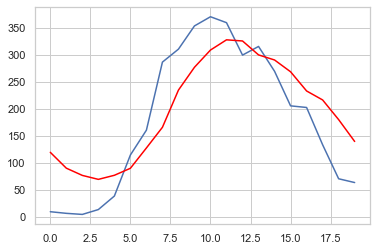

In [67]:
pred_sets=drift_topk_models_input(models, data_train, data_test,10,val_length,ker)
import matplotlib.pyplot as plt
plt.plot(list(pred_sets['val_ts']))
plt.plot(list(pred_sets['pred_pls_sim']), color='red')
plt.show()

In [19]:
from scipy.stats.stats import pearsonr
import math 

def rnormc1(ts1, ts2):
    mt = pd.concat([ts1,ts2], axis=1)
    c = mt.corr(method='pearson')
    #rn = math.sqrt((1-c)/2)
    a = [[0,0],[0,0]]
    for i in range(len(c.index)):
        for j in range(len(c.columns)):
            rn = math.sqrt((1-c.iloc[i, j])/2)
            a[i][j] = rn
            #print(a[i][j])
    
    return(a)

In [20]:
def topk_model_sel(models, data_train, data_test, val_length, ker):
    t = 1
    n = []
    
    updated_selection = []
    updated_selection.append([])
    updated_selection.append([])
    
    output_m = drift_topk_models_input(models, data_train, data_test,t,val_length,ker)
    
    
    
    m = output_m.corr(method='pearson')
    k1 = abs(m)
    
    k1.replace([np.inf, -np.inf], 0)
    k1_selected_row_to_sort = k1.iloc[0, :]
    k1_selected_row_to_sort_list = k1_selected_row_to_sort.index.to_list()
    
    k1_sorted_values = k1_selected_row_to_sort.sort_values(axis = 0, ascending = False)
    k1_sorted_values_list = k1_sorted_values.index[0:tp1].to_list()
    
    mdl_sel=[]
    for x in k1_sorted_values_list:
        for y in k1_selected_row_to_sort_list:
            if x == y:
                mdl_sel.append(k1_selected_row_to_sort_list.index(y))
                
    k1_temp = {}
    k1_temp_values=[]
    k1_temp_mdl_names = []
    for i in mdl_sel[-tp1 + 1: ]:
        #k1_temp.append(k1.iloc[0, i])
        k1_temp[k1.iloc[0].index[i]] = k1.iloc[0, i]
    for i in k1_temp:
        k1_temp_values.append(k1_temp[i])
        k1_temp_mdl_names.append(i)
        
    k1_temp_values = np.array(k1_temp_values)
    v1 = {}
    mdl_sel_temp = mdl_sel
    mdl_sel_temp = mdl_sel_temp[-tp1 + 1 : ]
    for i in mdl_sel_temp:
        if k1.iloc[0,i] > lim :
            v1[k1.iloc[0].index[i]] = mdl_sel_temp.index(i)
            
    if len(v1) > 0:
        mdl_sel_temp.insert(0, 0)
        mdl_sel1 = mdl_sel_temp
        
    #test = rnormc1(output_m.iloc[ :,0],output_m.iloc[ :,mdl_sel[1]])[0][1]
    #mt = pd.concat([output_m.iloc[ :,0],output_m.iloc[ :,mdl_sel[1]]], axis=1)
    rnormc1_list = []
    for i in range(1, tp1):
        x = rnormc1(output_m.iloc[ :,0],output_m.iloc[ :,mdl_sel[i]])[0][1]
        rnormc1_list.append(x)
        
    min_d = min(rnormc1_list)
    
    updated_selection[0] = mdl_sel1
    n.append(0)
    t = 2
    
    while (t <= len(test_reg)):
        
        st = datetime.now()
        output_m1 = drift_topk_models_input(models, data_train, data_test,t,val_length,ker)
        ed = datetime.now()
        
        m1 = output_m1.corr(method='pearson')
        
        k2 = abs(m1)
        k2.replace([np.inf, -np.inf], 0)
        
        #mdl.sel
        k2_selected_row_to_sort = k2.iloc[0, :]
        k2_selected_row_to_sort_list = k2_selected_row_to_sort.index.to_list()
    
        k2_sorted_values = k2_selected_row_to_sort.sort_values(axis = 0, ascending = False)
        k2_sorted_values_list = k2_sorted_values.index[0:tp1].to_list()
    
        mdl_sel=[]
        for x in k2_sorted_values_list:
            for y in k2_selected_row_to_sort_list:
                if x == y:
                    mdl_sel.append(k2_selected_row_to_sort_list.index(y))
        
        ######
        rnormc1_list = []
        for i in range(1, tp1):
            x = rnormc1(output_m1.iloc[ :,0],output_m1.iloc[ :,mdl_sel[i]])[0][1]
            rnormc1_list.append(x)
        
        l_cor = min(rnormc1_list)
        ######
        
        dd = min_d - l_cor
        
        if dd is None:
            dd = 0
        
        if(abs(dd) > math.sqrt(math.log(1/0.95)/(2*len(output_m1)))):
#             ddff = True
            mdl_sel1 = mdl_sel
            min_d = l_cor
            
        
            v = {}
            mdl_sel_temp = mdl_sel
            mdl_sel_temp = mdl_sel_temp[-tp1 + 1 : ]
            for i in mdl_sel_temp:
                if k2.iloc[0,i] > lim :
                    v[k2.iloc[0].index[i]] = mdl_sel_temp.index(i)
            if len(v) > 0:
                mdl_sel_temp.insert(0, 0)
                mdl_sel1 = mdl_sel_temp
            
            updated_selection.append(mdl_sel1)
            
            n.append(1)
            ddff = True
        else:
            
            updated_selection.append(mdl_sel1)
            n.append(0)
            ddff = False
        
        
        
        t = t + 1
        if t > len(test_reg):
            break
    
    keys = ['alarm', 'models_sel']
    values = [n, updated_selection]
    dictionary = dict(zip(keys, values))
    
    return(dictionary)
    

In [21]:
updated_selection = topk_model_sel(models, data_train, data_test,val_length,ker)
updated_selection1 = updated_selection['models_sel']
print(updated_selection1)
print(len(updated_selection1))
# selection.pop(1)

[[0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19,

In [22]:
print(updated_selection1[1])

[]


In [23]:
updated_selection1[1] = updated_selection1[0]
print(updated_selection1)

[[0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17, 9, 11], [0, 6, 5, 7, 8, 12, 21, 14, 22, 20, 10, 19, 17,

In [24]:
alarm = updated_selection['alarm']
print(alarm)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

## 1.Top model clustering using IMLEC and then aggregation in a sliding window ensemble
## clusters are updated with each drift detection

In [25]:
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    sm = (abs(y_true - y_pred))/ (abs(y_true) + abs(y_pred))
    return (sum(sm) * (1/len(y_true)))

In [26]:
list_pred=[354, 351, 276, 267, 244, 175, 171, 130,  59,  29]
list_true=[360, 300, 316, 270, 206, 203, 134,  71,  64,  41]
print(smape(list_true,list_pred))


0.09453398450852098


In [27]:
print(smape(list_pred,list_true))

0.09453398450852098


In [28]:
H = 10
st = datetime.now()
val_length1 = 10 # number of features for the cluster (predictionss of the models)

In [29]:
# print(t)

In [71]:
def calculensemble(H, pr, list_pred, real):
    rtest =[]
    for i in range(len(list_pred)):
        rtest_temp = []
        for j in range(H):
            rtest_temp.append(list_pred[i][(pr-H-1+j)])
        rtest.append(rtest_temp)   
    
    real = list(real)
    xtest = []
    for i in range(H):
        xtest.append(real[(pr-H-1+i)])
    
    
    ro = []
    for i in range(len(list_pred)):
        smape_value = smape(rtest[i], xtest)
        ro.append(smape_value)
    
    base = importr('base')
    pos = base.which(ro==inf)

    if len(pos) > 0 :
        ro[pos] = base.rep(1, len(pos))

    ro_in = []
    for item in ro:
        ro_in.append(1/item)
    gama = sum(ro_in)
    preds = []

    ro_in = np.asarray(ro_in)

    for i in range(len(list_pred)):
        preds.append((np.asarray(list_pred[i])*ro_in[i]))

    preds_tt = list(map(list, zip(*preds)))
    r = (sum(preds_tt[pr-1])/gama)
    return r

In [72]:
pred_test_sssss = calculensemble(H, 687, pred_list, predictions_table.iloc[ :, 0])

NameError: name 'pred_list' is not defined

#### compute_cluster_imlec Function

In [69]:
def compute_cluster_imlec():
    pred = []
    tr_model = []
# tr_model.append([])
# tr_model.append([])
    pred[0:(H)] = predictions_table.iloc[0:(H), 0]
# print(pred)
    sel_models = pd.DataFrame()
    sel_models_array = []
    for t in range(1,H + 1):
        alarm = updated_selection['alarm']
        selection = updated_selection['models_sel']
#     selection.pop(1)
        output_m = drift_topk_models_input(models, data_train, data_test,t,val_length,ker)
        for i in output_m.iloc[ :, selection[t][0]]:
        
            sel_models_res = output_m.iloc[ :, selection[t][1:]].apply(lambda x: abs(x-i) )
    
        sel_models = output_m.iloc[ :, selection[t][1:]]
        k_max = round(len(sel_models.columns)/2) - 1
    
        if(len(sel_models.columns) < 4):
            names_rep = sel_models.columns
        else :
            try:
                otrimle = importr('otrimle')
#             data= sel_models.transpose()
                a = otrimle.otrimle(data = sel_models.transpose(), G = k_max, ncores = 1)
            except:
                a = 0
#             print('An exception occured.')
            
#         newa = [s for s in a if s.isdigit()]
            if(a==0):
                G = k_max
                while (a==0):
                    base = importr('base')
                    try:
                        a = otrimle.otrimle(data = sel_models.transpose(), G = k_max, ncores = 1, 
                                            initial = base.sample(G, size = len(sel_models.columns), replace = True))
                    except:
                        a = 0
#                     print('An exception occured.')
        
            c1_array = np.array(a[12]).astype(int)
            keys = sel_models.columns
            c1 = dict(zip(keys, c1_array))
#         names_rep = []
            if(k_max == 1):
                names_rep = []
                for x, y in c1.items():
                    if y == 1 :
                        names_rep.append(x)
            else:
                names_rep = []
                vec = []
                for i in range(k_max):
                    vec.append(i+1)
            
                dd_list=[]
                for x in vec:
                    d_list = []
                    for item in c1:
                        if x == c1[item]:
                            d_list.append(item)
                    dd_list.append(d_list)
                for i in dd_list:
                    names_rep.append(i[0])
    
        pos_models = []
        for x in names_rep:
            for y in list(output_m.columns):
                if x==y:
                    pos_models.append(y)
#     i = t-1
        tr_model.append(pos_models)
    t = (H+1)

    alarm = updated_selection['alarm']
    selection = updated_selection['models_sel']
# print(len(selection))
    output_m = drift_topk_models_input(models, data_train, data_test,t,val_length,ker)
    for i in output_m.iloc[ :, selection[t][0]]:
        sel_models_res = output_m.iloc[ :, selection[t][1:]].apply(lambda x: abs(x-i) )

    sel_models = output_m.iloc[ :, selection[t][1:]]
    k_max = round(len(sel_models.columns)/2) - 1
    if(len(sel_models.columns) < 4):
        names_rep = sel_models.columns
    else:
        try:
            otrimle = importr('otrimle')
#       data= sel_models.transpose()
            a = otrimle.otrimle(data = sel_models.transpose(), G = k_max, ncores = 1)
        except:
            a = 0
#         print('An exception occured.')
            
#         newa = [s for s in a if s.isdigit()]
        if(a==0):
            G = k_max
            while (a==0):
                base = importr('base')
                try:
                    a = otrimle.otrimle(data = sel_models.transpose(), G = k_max, ncores = 1, 
                                        initial = base.sample(G, size = len(sel_models.columns), replace = True))
                except:
                    a = 0
#                 print('An exception occured.')
        
        c1_array = np.array(a[12]).astype(int)
        keys = sel_models.columns
        c1 = dict(zip(keys, c1_array))
#         names_rep = []
        if(k_max == 1):
            names_rep = []
            for x, y in c1.items():
                if y == 1 :
                    names_rep.append(x)
        else:
            names_rep = []
            vec = []
            for i in range(k_max):
                vec.append(i+1)
            
            dd_list=[]
            for x in vec:
                d_list = []
                for item in c1:
                    if x == c1[item]:
                        d_list.append(item)
                dd_list.append(d_list)
            for i in dd_list:
                names_rep.append(i[0])


    pos_models = []
    for x in names_rep:
        for y in list(output_m.columns):
            if x==y:
                pos_models.append(y)
#     i = t-1
    tr_model.append(pos_models)

    pred_list = []
    for i in range(len(pos_models)):
        pred_list_temp = list(predictions_table.loc[ :, pos_models[i]])
        pred_list.append(pred_list_temp)

    pred.append(calculensemble(H, t, pred_list, predictions_table.iloc[ :, 0]))
    t = t + 1
    while (t <= len(data_test)):
    
        if alarm[t-1] == 1 :
            output_m = drift_topk_models_input(models, data_train, data_test,t,val_length,ker)
#         print(len(selection))
            for i in output_m.iloc[ :, selection[t][0]]:
                sel_models_res = output_m.iloc[ :, selection[t][1:]].apply(lambda x: abs(x-i) )
    
            sel_models = output_m.iloc[ :, selection[t][1:]]
            k_max = round(len(sel_models.columns)/2) - 1
            if(len(sel_models.columns) < 4):
                names_rep = sel_models.columns
            else:
                try:
                    otrimle = importr('otrimle')
#       data= sel_models.transpose()
                    a = otrimle.otrimle(data = sel_models.transpose(), G = k_max, ncores = 1)
                except:
                    a = 0
#                 print('An exception occured.')
            
#         newa = [s for s in a if s.isdigit()]
                if(a==0):
                    G = k_max
                    while (a==0):
                        base = importr('base')
                        try:
                            a = otrimle.otrimle(data = sel_models.transpose(), G = k_max, ncores = 1, 
                                                initial = base.sample(G, size = len(sel_models.columns), replace = True))
                        except:
                            a = 0
#                         print('An exception occured.')
        
                c1_array = np.array(a[12]).astype(int)
                keys = sel_models.columns
                c1 = dict(zip(keys, c1_array))
                names_rep = []
                if(k_max == 1):
#                 names_rep = []
                    for x, y in c1.items():
                        if y == 1 :
                            names_rep.append(x)
                else:
                    try:
                    
#                 names_rep = []
                        vec = []
                        for i in range(k_max):
                            vec.append(i+1)

                        dd_list=[]
                        for x in vec:
                            d_list = []
                            for item in c1:
                                if x == c1[item]:
                                    d_list.append(item)
                            dd_list.append(d_list)
                        for ii in dd_list:
                            if (len(ii) != 0):
                                names_rep.append(ii[0])
                    except:
                        print(t)
                        print(c1)
                        print(k_max)
            
#             output_m_columns_list = []
#             for j in range(1:len(output_m.columns)):
            
            
            pos_models = []
            for x in names_rep:
                for y in list(output_m.columns):
                    if x==y:
                        pos_models.append(y)
#     i = t-1
            tr_model.append(pos_models)

            pred_list = []
            for i in range(len(pos_models)):
                pred_list_temp = list(predictions_table.loc[ :, pos_models[i]])
                pred_list.append(pred_list_temp)

            pred.append(calculensemble(H, t, pred_list, predictions_table.iloc[ :, 0]))
    
        else :
            pred_list = []
            for i in range(len(pos_models)):
                pred_list_temp = list(predictions_table.loc[ :, pos_models[i]])
                pred_list.append(pred_list_temp)
        
            pred.append(calculensemble(H, t, pred_list, predictions_table.iloc[ :, 0]))
            tr_model.append(pos_models)
    
        t = t + 1
        if t > len(data_test):
            break



# print(True)
    import matplotlib.pyplot as plt
    plt.plot(list(data_test['target']))
    plt.plot(list(pred), color='red')
    plt.show()
    print(sqrt(mean_squared_error(data_test['target'], pred)))
    
    keys = ['predictions', 'selected_models_id']
    values = [pred, tr_model]
    dictionary = dict(zip(keys, values))
    
    return(dictionary)


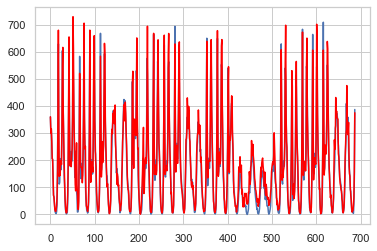

47.365525231608274


In [70]:
tp_cl = compute_cluster_imlec()

In [ ]:
ed = datetime.now()
pred_tp_imlec = tp_cl['predictions']
pos_models = tp_cl['selected_models_id']
print(sqrt(mean_squared_error(data_test['target'], pred_tp_imlec)))

In [ ]:
# print(data_test['target'])

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(list(data_test['target']))
# plt.show()

In [ ]:
# plt.plot(list(tp_cl['predictions']), color='red')
# plt.show()

In [ ]:
# print(sqrt(mean_squared_error(data_test['target'], tp_cl['predictions'])))

##  2. Top model clustering using IMLEC and then combination using stacking

In [73]:
pos_models = tp_cl['selected_models_id']
st = datetime.now()
val_length1 = 50 #increase length of the validation set because it will be used for the training of the meta-learner

In [74]:
output_m = drift_topk_models_input(models, data_train, data_test,1,val_length1,ker)
models_test_list = list(output_m.columns)
inds_list = []
for i in range(len(pos_models)):
    inds = []
    for j in range(len(pos_models[i])):
        for k in range(len(models_test_list)):
            if models_test_list[k] == pos_models[i][j]:
                inds.append(models_test_list.index(models_test_list[k]))
    inds_list.append(inds)
# print(inds_list)

pos_models = inds_list
print(pos_models)

[[6, 8, 12, 14, 10, 19], [6, 8, 12, 14, 10, 19], [6, 7, 8, 12, 14, 19], [6, 8, 12, 14, 10, 19], [6, 8, 12, 14, 10, 19], [6, 8, 12, 14, 10, 19], [7, 8, 12, 14, 19, 17], [7, 8, 12, 14, 19, 17], [7, 8, 12, 14, 19, 17], [6, 5, 8, 12, 14, 10], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 

In [75]:
print(len(pos_models))

688


###### Compute IMLEC clustering using stacking at drift detection : for comparision for the paper

In [76]:
pos_models = tp_cl['selected_models_id']
st = datetime.now()
val_length1 = 50 #increase length of the validation set because it will be used for the training of the meta-learner

inds_list = []
for i in range(len(pos_models)):
    inds = []
    for j in range(len(pos_models[i])):
        for k in range(len(models_test_list)):
            if models_test_list[k] == pos_models[i][j]:
                inds.append(models_test_list.index(models_test_list[k]))
    inds_list.append(inds)
# print(inds_list)

pos_models = inds_list
print(pos_models)

[[6, 8, 12, 14, 10, 19], [6, 8, 12, 14, 10, 19], [6, 7, 8, 12, 14, 19], [6, 8, 12, 14, 10, 19], [6, 8, 12, 14, 10, 19], [6, 8, 12, 14, 10, 19], [7, 8, 12, 14, 19, 17], [7, 8, 12, 14, 19, 17], [7, 8, 12, 14, 19, 17], [6, 5, 8, 12, 14, 10], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 12, 14], [6, 5, 7, 8, 

In [77]:
def compute_cl_tp_imlec_stac():
    

    #############################################################################################################3

    t = 1
    alarm = updated_selection['alarm']
    pred_rfst = None
    pred_rbrst = None
    pred_glmst = None
    pred_svrst = None
    pred_marsst = None
    pred_gbmst = None
    pred_pprst = None
    pred_mlpst = None
    pred_gpst = None
    pred_plsst = None
    pred_dtst = None
    rf_st = None
    rbr_st = None
    glm_st = None
    svr_st = None
    mars_st = None
    gbm_st = None
    ppr_st = None
    mlp_st = None
    gp_st = None
    pls_st = None
    dt_st = None

    mean_pred = None

    output_m = drift_topk_models_input(models, data_train, data_test,t,val_length1,ker)

    models_test_list = list(output_m.columns)


    sel_models = output_m.iloc[ :, 0].to_frame()

    for item in pos_models[t-1]:
        sel_models[output_m.iloc[ :, item].name] = output_m.iloc[ :, item]

    x = sel_models.iloc[:, 1:len(sel_models.columns)]
    y = sel_models.iloc[:,0]

    train_st = sel_models
    fmla1 = Formula('val_ts~.')

    # pos_models[t-1].insert(0,0)

    x_1 = predictions_table.iloc[t-1, :].to_frame()
    x_1 = x_1.T


    pos_models[t-1].insert(0,0)

    test_st_columns_list = []
    for i in pos_models[t-1]:
        test_st_columns_list.append(models_test_list[i])

    test_st = pd.DataFrame(columns=test_st_columns_list)

    lll = []
    for item in test_st_columns_list:
        lll.append(x_1.iloc[0][item])
    test_st.loc[x_1.index.values[0]] = lll


    x_test = test_st.iloc[:, 1:len(sel_models.columns)]
    y_test = test_st.iloc[:, 0]

    pos_models_k = pos_models[t-1]
    pos_models_k.pop(0)

    randomForest = importr('randomForest')
    rf_st = randomForest.randomForest(fmla1, data=train_st, ntree=10)

    predict = ro.r['predict']

    pred_rfst = []
    pred_rfst.append(predict(rf_st, test_st, type="response")[0])

    cubist = importr('Cubist')
    rbr_st = cubist.cubist(x, y, committees=1, control=cubist.cubistControl())

    pred_rbrst = []
    pred_rbrst.append(cubist.predict_cubist(rbr_st, x_test)[0])

    glmnet = importr('glmnet')
    rmatrix = ro.r['as.matrix']
    x_glmnet = rmatrix(x)
    glm_st = glmnet.glmnet(x_glmnet, y, alpha=0.2, nlambda=20)

    pred_glmst = []
    pred_glmst.append(predict(glm_st, newx = rmatrix(x_test), type='response')[9])

    kernlab = importr('kernlab')
    svr_st = kernlab.ksvm(fmla1, data=train_st, type="eps-svr", kernel=ker[2], kpar="automatic", prob_model=True)

    pred_svrst = []
    pred_svrst.append(predict(svr_st, test_st, type='response')[0])

    mda = importr('mda')
    mars_st = mda.mars(x = train_st.iloc[:, 1:len(train_st.columns)], y = train_st.iloc[:,0], degree = 1, nk = 7)

    pred_marsst = []
    pred_marsst.append(predict(mars_st, x_test, type='response')[0])

    gbm = importr('gbm')
    gbm_st = gbm.gbm(fmla1, data=train_st, n_trees=2)

    pred_gbmst = []
    pred_gbmst.append(gbm.predict_gbm(gbm_st, x_test, n_trees=10, type='response')[0])

    stats = importr('stats')
    ppr_st = stats.ppr(fmla1, data=train_st, nterms=5, max_terms=5)

    pred_pprst = []
    pred_pprst.append(predict(ppr_st, x_test, type='response')[0])

    # monmlp model
    monmlpp = importr('monmlp')
    rmatrix = ro.r['as.matrix']
    X = rmatrix(train_st.iloc[:, 1:len(train_st.columns)])
    y = rmatrix(train_st.iloc[:, 0])

    mlp_st = monmlpp.monmlp_fit(x=X, y=y, hidden1=5, n_ensemble=1, bag=False, silent=True)

    pred_mlpst = []
    rvector = ro.r['as.vector']
    monmlpp = importr('monmlp')
    X_test_st = rmatrix(test_st.iloc[:, 1:len(test_st.columns)])
    pred_mlp_st = rvector(monmlpp.monmlp_predict(X_test_st, mlp_st))
    np.asarray(pred_mlp_st)
    pred_mlp_st_list=[]
    for x in pred_mlp_st:
        pred_mlp_st_list.append(x)

    pred_mlpst.append(pred_mlp_st_list[0])

    gp_st = kernlab.gausspr(fmla1, data=train_st, type='regression', kernel=ker[2], kpar='automatic', prob_model=True)

    pred_gpst = []
    pred_gp_st = rvector(predict(gp_st, test_st, type='response'))
    np.asarray(pred_gp_st)
    pred_gp_st_list=[]
    for x in pred_gp_st:
        pred_gp_st_list.append(x)
    pred_gpst.append(pred_gp_st_list[0])

    pls = importr('pls')
    pls_st = pls.plsr(fmla1, data=train_st, validation='CV', method='simpls')

    pred_plsst = []
    pred_pls_st = predict(pls_st, test_st, type='response', ncomp=1)
    rvector = ro.r['as.vector']
    pred_pls_st = rvector(pred_pls_st)
    np.asarray(pred_pls_st)
    pred_pls_st_list=[]
    for x in pred_pls_st:
        pred_pls_st_list.append(x)
    pred_plsst.append(pred_pls_st_list[0])

    rpart = importr('rpart')
    dt_st = rpart.rpart(fmla1, method='anova', data=train_st)

    pred_dtst = []
    pred_dtst.append(predict(dt_st, test_st)[0])

    # vec_pred = [pred_rfst, pred_rbrst, pred_glmst, pred_svrst, pred_gpst, pred_plsst]
    # vec_pred_list = []
        
    # for i in range(len(vec_pred)):
    # #             print(vec_pred[i][1])
    #     vec_pred_list.append(vec_pred[i][1])

    # mean_pred = []
    # mean_pred.append(mean(vec_pred_list))

    vec_pred = [pred_rfst[t-1], pred_rbrst[t-1], pred_glmst[t-1], pred_svrst[t-1], pred_gpst[t-1], pred_plsst[t-1]]
    vec_pred_list = []
    # print(vec_pred)
    for i in range(len(vec_pred)):
    #             print(vec_pred[i][1])
    #     print(i)
        vec_pred_list.append(vec_pred[i])

    #         mean_pred = []
    # print("####################first")
    # print(t)
    # print(vec_pred)
    mean_pred = []
    mean_pred.append(mean(vec_pred_list))
    # print(mean_pred)

    t = t + 1

    while (t <= len(data_test)):
    
        if alarm[t-1]==1:
        
            output_m = drift_topk_models_input(models, data_train, data_test,t,val_length1,ker)
        
            sel_models = output_m.iloc[ :, 0].to_frame()

            for item in pos_models[t-1]:
                sel_models[output_m.iloc[ :, item].name] = output_m.iloc[ :, item]

            x = sel_models.iloc[:, 1:len(sel_models.columns)]
            y = sel_models.iloc[:,0]

            train_st = sel_models
            fmla1 = Formula('val_ts~.')
        
            x_1 = predictions_table.iloc[t-1, :].to_frame()
            x_1 = x_1.T


            pos_models[t-1].insert(0,0)

            test_st_columns_list = []
            for i in pos_models[t-1]:
                test_st_columns_list.append(models_test_list[i])

            test_st = pd.DataFrame(columns=test_st_columns_list)

            lll = []
            for item in test_st_columns_list:
                lll.append(x_1.iloc[0][item])
            test_st.loc[x_1.index.values[0]] = lll


            x_test = test_st.iloc[:, 1:len(sel_models.columns)]
            y_test = test_st.iloc[:, 0]
        
            pos_models_k = pos_models[t-1]
            pos_models_k.pop(0)
        
    #         print(t)
    #         print(x_test)
        
    #         randomForest = importr('randomForest')
            rf_st = randomForest.randomForest(fmla1, data=train_st, ntree=10)

    #         predict = ro.r['predict']

    #         pred_rfst = []
            pred_rfst.append(predict(rf_st, test_st, type="response")[0])

    #         cubist = importr('Cubist')
            rbr_st = cubist.cubist(x, y, committees=1, control=cubist.cubistControl())

    #         pred_rbrst = []
            pred_rbrst.append(cubist.predict_cubist(rbr_st, x_test)[0])
        
    #         glmnet = importr('glmnet')
    #         rmatrix = ro.r['as.matrix']
            x_glmnet = rmatrix(x)
            glm_st = glmnet.glmnet(x_glmnet, y, alpha=0.2, nlambda=20)

    #         pred_glmst = []
            pred_glmst.append(predict(glm_st, newx = rmatrix(x_test), type='response')[9])
        
    #         kernlab = importr('kernlab')
            svr_st = kernlab.ksvm(fmla1, data=train_st, type="eps-svr", kernel=ker[2], kpar="automatic", prob_model=True)

    #         pred_svrst = []
            pred_svrst.append(predict(svr_st, test_st, type='response')[0])
    
    #         mda = importr('mda')
            mars_st = mda.mars(x = train_st.iloc[:, 1:len(train_st.columns)], y = train_st.iloc[:,0], degree = 1, nk = 7)

    #         pred_marsst = []
            pred_marsst.append(predict(mars_st, x_test, type='response')[0])
    
    #         gbm = importr('gbm')
            gbm_st = gbm.gbm(fmla1, data=train_st, n_trees=2)

    #         pred_gbmst = []
            pred_gbmst.append(gbm.predict_gbm(gbm_st, x_test, n_trees=10, type='response')[0])
    
    #         stats = importr('stats')
            ppr_st = stats.ppr(fmla1, data=train_st, nterms=5, max_terms=5)

    #         pred_pprst = []
            pred_pprst.append(predict(ppr_st, x_test, type='response')[0])
        
    #         monmlpp = importr('monmlp')
    #         rmatrix = ro.r['as.matrix']
            X = rmatrix(train_st.iloc[:, 1:len(train_st.columns)])
            y = rmatrix(train_st.iloc[:, 0])

            mlp_st = monmlpp.monmlp_fit(x=X, y=y, hidden1=5, n_ensemble=1, bag=False, silent=True)

    #         pred_mlpst = []
    #         rvector = ro.r['as.vector']
    #         monmlpp = importr('monmlp')
            X_test_st = rmatrix(test_st.iloc[:, 1:len(test_st.columns)])
            pred_mlp_st = rvector(monmlpp.monmlp_predict(X_test_st, mlp_st))
            np.asarray(pred_mlp_st)
            pred_mlp_st_list=[]
            for x in pred_mlp_st:
                pred_mlp_st_list.append(x)

            pred_mlpst.append(pred_mlp_st_list[0])
        
        
            gp_st = kernlab.gausspr(fmla1, data=train_st, type='regression', kernel=ker[2], kpar='automatic', prob_model=True)

    #         pred_gpst = []
            pred_gp_st = rvector(predict(gp_st, test_st, type='response'))
            np.asarray(pred_gp_st)
            pred_gp_st_list=[]
            for x in pred_gp_st:
                pred_gp_st_list.append(x)
            pred_gpst.append(pred_gp_st_list[0])
        
    #         pls = importr('pls')
            pls_st = pls.plsr(fmla1, data=train_st, validation='CV', method='simpls')

    #         pred_plsst = []
            pred_pls_st = predict(pls_st, test_st, type='response', ncomp=1)
    #         rvector = ro.r['as.vector']
            pred_pls_st = rvector(pred_pls_st)
            np.asarray(pred_pls_st)
            pred_pls_st_list=[]
            for x in pred_pls_st:
                pred_pls_st_list.append(x)
            pred_plsst.append(pred_pls_st_list[0])
        
    #         rpart = importr('rpart')
            dt_st = rpart.rpart(fmla1, method='anova', data=train_st)

    #         pred_dtst = []
            pred_dtst.append(predict(dt_st, test_st)[0])
    #         print(t)
    #         vec_pred = [pred_rfst, pred_rbrst, pred_glmst, pred_svrst, pred_gpst, pred_plsst]
            vec_pred = [pred_rfst[t-1], pred_rbrst[t-1], pred_glmst[t-1], pred_svrst[t-1], pred_gpst[t-1], pred_plsst[t-1]]
            vec_pred_list = []
        
            for i in range(len(vec_pred)):
    #             print(vec_pred[i][1])
                vec_pred_list.append(vec_pred[i])
        
    #         print("####################if")
    #         print(t)
    #         print(vec_pred)
    #         mean_pred = []
            mean_pred.append(mean(vec_pred_list))
    #         print(mean_pred)
    
        
        
        else:
    #         print(t)
    #         print(pos_models_k)
        
            output_m = drift_topk_models_input(models, data_train, data_test,t,val_length1,ker)
        
            sel_models = output_m.iloc[ :, 0].to_frame()

            for item in pos_models_k:
                sel_models[output_m.iloc[ :, item].name] = output_m.iloc[ :, item]

            x = sel_models.iloc[:, 1:len(sel_models.columns)]
            y = sel_models.iloc[:,0]

            train_st = sel_models
            fmla1 = Formula('val_ts~.')
        
            x_1 = predictions_table.iloc[t-1, :].to_frame()
            x_1 = x_1.T


            pos_models_k.insert(0,0)

            test_st_columns_list = []
            for i in pos_models_k:
                test_st_columns_list.append(models_test_list[i])

            test_st = pd.DataFrame(columns=test_st_columns_list)

            lll = []
            for item in test_st_columns_list:
                lll.append(x_1.iloc[0][item])
            test_st.loc[x_1.index.values[0]] = lll


            x_test = test_st.iloc[:, 1:len(sel_models.columns)]
            y_test = test_st.iloc[:, 0]
    #         print('else')
    #         print(t)
    #         print(x_test)
    #         break
        
    #         pos_models_k = pos_models[t-1]
            pos_models_k.pop(0)
        
    #         randomForest = importr('randomForest')
    #         rf_st = randomForest.randomForest(fmla1, data=train_st, ntree=10)

    #         predict = ro.r['predict']

    #         pred_rfst = []
            pred_rfst.append(predict(rf_st, test_st, type="response")[0])
    #         print("###############rfst")
    #         print(pred_rfst)

    #         cubist = importr('Cubist')
    #         rbr_st = cubist.cubist(x, y, committees=1, control=cubist.cubistControl())

    #         pred_rbrst = []
            pred_rbrst.append(cubist.predict_cubist(rbr_st, x_test)[0])
        
    #         glmnet = importr('glmnet')
    #         rmatrix = ro.r['as.matrix']
    #         x_glmnet = rmatrix(x)
    #         glm_st = glmnet.glmnet(x_glmnet, y, alpha=0.2, nlambda=20)

    #         pred_glmst = []
            pred_glmst.append(predict(glm_st, newx = rmatrix(x_test), type='response')[9])
        
    #         kernlab = importr('kernlab')
    #         svr_st = kernlab.ksvm(fmla1, data=train_st, type="eps-svr", kernel=ker[2], kpar="automatic", prob_model=True)

    #         pred_svrst = []
            pred_svrst.append(predict(svr_st, test_st, type='response')[0])
    
    #         mda = importr('mda')
    #         mars_st = mda.mars(x = train_st.iloc[:, 1:len(train_st.columns)], y = train_st.iloc[:,0], degree = 1, nk = 7)

    #         pred_marsst = []
            pred_marsst.append(predict(mars_st, x_test, type='response')[0])
    
    #         gbm = importr('gbm')
    #         gbm_st = gbm.gbm(fmla1, data=train_st, n_trees=2)

    #         pred_gbmst = []
            pred_gbmst.append(gbm.predict_gbm(gbm_st, x_test, n_trees=10, type='response')[0])
    
    #         stats = importr('stats')
    #         ppr_st = stats.ppr(fmla1, data=train_st, nterms=5, max_terms=5)

    #         pred_pprst = []
            pred_pprst.append(predict(ppr_st, x_test, type='response')[0])
        
    #         monmlpp = importr('monmlp')
    #         rmatrix = ro.r['as.matrix']
    #         X = rmatrix(train_st.iloc[:, 1:len(train_st.columns)])
    #         y = rmatrix(train_st.iloc[:, 0])

    #         mlp_st = monmlpp.monmlp_fit(x=X, y=y, hidden1=5, n_ensemble=1, bag=False, silent=True)

    #         pred_mlpst = []
    #         rvector = ro.r['as.vector']
    #         monmlpp = importr('monmlp')
            X_test_st = rmatrix(test_st.iloc[:, 1:len(test_st.columns)])
            pred_mlp_st = rvector(monmlpp.monmlp_predict(X_test_st, mlp_st))
            np.asarray(pred_mlp_st)
            pred_mlp_st_list=[]
            for x in pred_mlp_st:
                pred_mlp_st_list.append(x)

            pred_mlpst.append(pred_mlp_st_list[0])
        
        
    #         gp_st = kernlab.gausspr(fmla1, data=train_st, type='regression', kernel=ker[2], kpar='automatic', prob_model=True)

    #         pred_gpst = []
            pred_gp_st = rvector(predict(gp_st, test_st, type='response'))
            np.asarray(pred_gp_st)
            pred_gp_st_list=[]
            for x in pred_gp_st:
                pred_gp_st_list.append(x)
            pred_gpst.append(pred_gp_st_list[0])
        
    #         pls = importr('pls')
    #         pls_st = pls.plsr(fmla1, data=train_st, validation='CV', method='simpls')

    #         pred_plsst = []
            pred_pls_st = predict(pls_st, test_st, type='response', ncomp=1)
    #         rvector = ro.r['as.vector']
            pred_pls_st = rvector(pred_pls_st)
            np.asarray(pred_pls_st)
            pred_pls_st_list=[]
            for x in pred_pls_st:
                pred_pls_st_list.append(x)
            pred_plsst.append(pred_pls_st_list[0])
        
    #         rpart = importr('rpart')
    #         dt_st = rpart.rpart(fmla1, method='anova', data=train_st)

    #         pred_dtst = []
            pred_dtst.append(predict(dt_st, test_st)[0])
    #         print(t)
    #         vec_pred = [pred_rfst, pred_rbrst, pred_glmst, pred_svrst, pred_gpst, pred_plsst]
            vec_pred = [pred_rfst[t-1], pred_rbrst[t-1], pred_glmst[t-1], pred_svrst[t-1], pred_gpst[t-1], pred_plsst[t-1]]
            vec_pred_list = []
        
            for i in range(len(vec_pred)):
    #             print(vec_pred[i][1])
                vec_pred_list.append(vec_pred[i])

    #         mean_pred = []
    #         print("####################else")
    #         print(t)
    #         print(vec_pred)
            mean_pred.append(mean(vec_pred_list))
    #         print(mean_pred)
        
    
        t = t + 1
        if t > len(data_test):
            break



    # print(mean_pred)
    # print(list(pred_rfst, pred_rbrst, pred_glmst, pred_svrst, pred_marsst, pred_gbmst, pred_pprst, pred_mlpst, pred_gpst, pred_plsst, pred_dtst, mean_pred))
    result_list = [pred_rfst, pred_rbrst, pred_glmst, pred_svrst, pred_marsst, pred_gbmst, pred_pprst, pred_mlpst, pred_gpst, pred_plsst, pred_dtst, mean_pred]
    # for item in range(len(result_list)):
    #     print("$$$$$$$$$$$$$$$$$$$$")
    #     print(item)
    #     print(result_list[item])
    # print(result_list)
    return (result_list)




In [78]:
pred_st_cl = compute_cl_tp_imlec_stac()

In [82]:
print(sqrt(mean_squared_error(data_test['target'], pred_st_cl[0])))

48.17949840186015


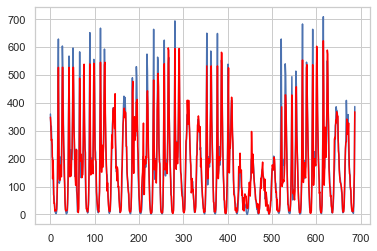

In [83]:
import matplotlib.pyplot as plt
plt.plot(list(data_test['target']))
plt.plot(list(pred_st_cl[0]), color='red')
plt.show()

In [81]:
print(pred_st_cl[0])

[348.89666666666665, 324.64500000000004, 265.29333333333335, 269.58, 248.01999999999998, 127.82166666666667, 194.45499999999998, 131.93666666666667, 40.38, 40.38, 12.126666666666665, 14.184999999999999, 14.184999999999999, 12.569999999999999, 18.316666666666666, 64.51333333333334, 127.905, 346.99000000000007, 527.3916666666667, 289.06, 127.76333333333335, 122.12166666666667, 123.82166666666667, 177.27666666666667, 137.67166666666668, 134.94166666666666, 310.17999999999995, 527.3916666666667, 527.3916666666667, 322.725, 249.59333333333333, 206.9, 124.78666666666668, 40.38, 16.041666666666664, 12.52, 13.36, 14.184999999999999, 15.716666666666665, 61.779999999999994, 128.37166666666667, 356.8466666666667, 527.3916666666667, 333.4083333333334, 134.94166666666666, 165.01666666666668, 177.27666666666667, 137.91666666666666, 213.38166666666666, 234.54666666666668, 344.91, 527.3916666666667, 527.3916666666667, 317.325, 268.71833333333336, 195.1, 132.00333333333336, 104.775, 131.34666666666666,

# ensemble on top best performing models using sliding window approach

In [ ]:
def ens_step(data_test, predictions_table, updated_selection1, t, H):
    if t<(H+1):
        pred = predictions_table.iloc[t-1, updated_selection1[t-1][1:][0]]
    else:
        cols = updated_selection1[t-1][1:]
        
        pred_list = []
        for i in range(len(cols)):
            pred_list_temp = list(predictions_table.iloc[ :, cols[i]])
            pred_list.append(pred_list_temp)
        
        pred = calculensemble(H, t, pred_list, predictions_table.iloc[:, 0])
    
    
    return(pred)

In [ ]:
# ens_step(data_test, predictions_table, updated_selection1, 200, 10)

### sliding window ensemble of the top base models

In [ ]:
def ens_top_pred(data_test, predictions_table, updated_selection1, H):
    
    pred_ens = []
    for i in range(len(data_test)):
        pred_ens.append(ens_step(data_test, predictions_table, updated_selection1, i+1, H))
    
    return(pred_ens)

In [ ]:
# ens_top_pred(data_test, predictions_table, updated_selection1, 10)

In [ ]:
H = 10

# pred_top = ens_top_pred(data_test, predictions_table, updated_selection1, H)

### ensemble on all the models using sliding window approach

In [ ]:
def ens_step_all(data_test, predictions_table, t , H):
    
    if t < (H+1):
        pred = predictions_table.iloc[t-1, 1]
    else:
        pred_list = []

        for i in range(1, len(predictions_table.columns)):
#             print(i)
            pred_list_temp = list(predictions_table.iloc[ :, i])
            pred_list.append(pred_list_temp)
            
        pred = calculensemble(H, t, pred_list, predictions_table.iloc[:, 0])
        
    return(pred)

In [ ]:
# ens_step_all(data_test, predictions_table, 20, H)

## sliding window ensemble of all the models in the pool

In [ ]:
pred_ens_all_sw = []
for i in range(len(data_test)):
    pred_ens_all_sw.append(ens_step_all(data_test, predictions_table, i+1, H))

### ensemble on all the models using simple average

In [ ]:
def ens_avg_all(data_test, predictions_table, t):
    predictions_table1 = predictions_table
    pred_list = []
    for i in range(1, len(predictions_table1.columns)):
        pred_list_temp = list(predictions_table1.iloc[ :, i])
        pred_list.append(pred_list_temp)
    
    preds = []
    for j in range(len(pred_list)):
        preds.append(pred_list[j])
    
    pred_list_for_mean = []
    for k in range(len(pred_list)):
        pred_list_for_mean.append(preds[k][t])
    
    pred = mean(pred_list_for_mean)
    
    return(pred)

In [ ]:
# print(ens_avg_all(data_test, predictions_table,0))

## average ensemble of all the models in the pool

In [ ]:
pred_ens_all = []
for i in range(len(data_test)):
    pred_ens_all.append(ens_avg_all(data_test, predictions_table, i))

In [ ]:
# print(len(pred_ens_all))

In [ ]:
pred_top = ens_top_pred(data_test, predictions_table, updated_selection1, H)

In [ ]:
print(mean_squared_error(data_test['target'], pred_top))

In [ ]:
print(sqrt(mean_squared_error(data_test['target'], pred_top)))

In [ ]:
print(sqrt(mean_squared_error(data_test['target'], pred_ens_all)))

In [ ]:
print(sqrt(mean_squared_error(data_test['target'], pred_ens_all_sw)))

# Top model clustering using k-means and then aggregation in a sliding window ensemble
# clusters are updated with each drift detection

In [ ]:
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return listOfKeys

In [ ]:
fmla = Formula('target~.')
val_length1 = 10

In [ ]:
def cluster_models(sel_models, k_max):
    
    try:
        m_cl = sel_models.transpose().to_numpy()
        factoextra = importr('factoextra')
        stats = importr('stats')
        ggplot2 = importr('ggplot2')
        opt_k_search = factoextra.fviz_nbclust(x=sel_models.transpose(), verbose=True, FUNcluster=stats.kmeans , nstart = 25, method='silhouette', nboot = 50, k_max = k_max) + ggplot2.labs(subtitle='silhouette')
    
        for item in range(len(((list(opt_k_search)[0])[1]))):
            if (((list(opt_k_search)[0])[1])[item]) == max((((list(opt_k_search)[0])[1]))):
                e = (((list(opt_k_search)[0])[0])[item])
#                 print((((list(opt_k_search)[0])[0])[item]))
    except:
        e=0
    
    if e==0:
        opt_k = 5
    else:
        opt_k = e
    c1_k = stats.kmeans(sel_models.transpose(), centers = opt_k)
    c1_k[0]
    
    names_rep = []
    base = importr('base')
    

    centers_matrix = c1_k[1]

    centers_list = []
    centers_list_row = []

    clusters = c1_k[0]
    item_i = 0


    for i in range(1, opt_k+1):
        cluster_names = []
        for j in range(len(clusters)):
            if clusters[j]==i:
                cluster_names.append(clusters.names[j])

        dd = []
        for item in clusters:
            if i == item:
                dd.append(item)

        if len(dd)==1:
            names_rep.append(cluster_names[0])

        else:
            sel_models_T = sel_models.transpose()

            items_sum = {}
            sel_models_T_row_values = {}
            for item in cluster_names:
                row_sums_list = {}
                for row in sel_models_T.index:

                    
                    if item == row:
                        sel_models_T_row_values_temp = {}
                        for k in range(val_length1):
                            sel_models_T_row_values_temp[item] = abs(sel_models_T.loc[row] - centers_matrix.rx(i, k+1))
                sel_models_T_row_values[item] = sel_models_T_row_values_temp.values()

            min_list = {}
            for k, v in sel_models_T_row_values.items():
                min_list[k] = (sum(list(v)))
            key_min = min(min_list.keys(), key=(lambda k: min_list[k]))

            listOfKeys = getKeysByValue(min_list, min_list[key_min])

            for item in listOfKeys:
                names_rep.append(item)
    
    
    

    return(names_rep)
            

In [ ]:
def compute_cluster(models, data_train, data_test, t, val_length, ker = ker):
    selection = updated_selection['models_sel']
    
    output_m = drift_topk_models_input(models, data_train, data_test,t,val_length,ker)
    for i in output_m.iloc[ :, selection[t][0]]:
        
        sel_models_res = output_m.iloc[ :, selection[t][1:]].apply(lambda x: abs(x-i) )
    
    sel_models = output_m.iloc[ :, selection[t][1:]]
    names_rep = []
    if len(sel_models.columns) < 7:
        names_rep = sel_models.columns
    else:
        names_rep = cluster_models(sel_models, len(sel_models.columns)-2)
    
    pos_models = [output_m.columns[0]]
#     print(output_m.columns[0])
    for x in names_rep:
        for y in list(output_m.columns):
            if x==y:
                pos_models.append(y)
    
    
    result_dict={}
    result_dict['names of selected models'] = names_rep[0]
    result_dict['list_position'] = pos_models
    result_dict['number of models'] = len(pos_models)
    
    return(result_dict)


In [ ]:
compute_cluster(models, data_train, data_test, 1, val_length1, ker)

In [ ]:
def update_cluster_kmeans(models, data_train, data_test, val_length, ker= ker):
    cluster_res = []
#     cluster_res.append([])
    n = updated_selection['alarm']
    
    base = importr('base')
#     
#     alarm = base.which(n==1)
#     print(n)
    alarm = []
    for item in range(len(n)):
        if n[item] == 1:
            alarm.append(item)
#     print(alarm)
    
    cluster_res.append(list(compute_cluster(models, data_train, data_test, 1, val_length, ker).values()))
#     print(alarm[len(alarm)-1])

    for t in range(1, alarm[0]-1):
        cluster_res.append(cluster_res[0])
#     print(len(cluster_res))
#     for i in range(len(alarm)-1):
#         cluster_res.append
    for i in range(len(alarm)-1):
        cluster_res.append(list(compute_cluster(models, data_train, data_test, alarm[i], val_length, ker).values()))
#         print(cluster_res[alarm[i]-1])
        r = alarm[i+1] - alarm[i]-1
        for j in range(r):
#             print(i)
            cluster_res.append(cluster_res[alarm[i]-1])
    
    cluster_res.append(list(compute_cluster(models, data_train, data_test, alarm[len(alarm)-1], val_length, ker).values()))
    
    
    for j in range(len(data_test)-alarm[len(alarm)-1]):
        cluster_res.append(cluster_res[alarm[i]])
    
    return(cluster_res)
#     cluster_res.append()


In [ ]:
cluster_res = update_cluster_kmeans(models, data_train, data_test, val_length1, ker= ker)

In [ ]:
pos_cl_temp = []
for i in range(len(cluster_res)):
    a = cluster_res[i][1]
    np.asarray(a)
    if len(a) >=4:
        cc = []
        for item in range(4):
            cc.append(a[item])
        pos_cl_temp.append(cc)
    else:
        
#         a = cluster_rep[i][1]
#         np.asarray(a)
        b = np.repeat(a[1], 3).tolist()
        b.insert(0, a[0])
#         print(b)
        pos_cl_temp.append(b)
#         pos_cl.append(b)
# print(pos_cl)

x = drift_topk_models_input(models, data_train, data_test,21,val_length,ker)
pos_cl = []
model_list = []
for i in x.columns:
    model_list.append(i)
# print(pos_cl)

for item in pos_cl_temp:
    models_temp = []
    for j in item:
        
        for i in range(len(model_list)):
            
            if model_list[i] == j:
                models_temp.append(i)
#     print(models_temp)
    pos_cl.append(models_temp)
print(pos_cl)


In [ ]:
pred_cl_kmeans = ens_top_pred(data_test, predictions_table, pos_cl, H)

In [ ]:
print(sqrt(mean_squared_error(data_test['target'], pred_cl_kmeans)))

# original model pool clustering using IMLEC and the aggregation in a sliding window ensemble

In [ ]:
val_length1 = 10

In [ ]:
def compute_cluster_or_all(models, data_train, data_test, val_length, H, ker= ker):
#     names_rep = []
    pred = []
#     dd_list= []
#     d_list = []
    pred[0:(H)] = predictions_table.iloc[0:(H), 0]
    
    t = (H+1)
    
    output_m = drift_topk_models_input(models, data_train, data_test,t,val_length,ker)
    
#     sel_models_temp = output_m.iloc[:,:]
    sel_models = output_m.drop(['val_ts', 'pred_mars_3_7', 'pred_mars_3_15', 'pred_dt'], axis=1)
    
    k_max = round(len(sel_models.columns)/2) - 1
#     c1 = {}
    try:
        otrimle = importr('otrimle')
        base = importr('base')
#             data= sel_models.transpose()
        a = otrimle.otrimle(data = sel_models.transpose(), G = k_max, ncores = 1, 
                                            initial = base.sample(G, size = len(sel_models.columns), replace = True))
    except:
        a = 0
    
    if(a==0):
        G = k_max
        while (a==0):
            try:
                otrimle = importr('otrimle')
                base = importr('base')
        #             data= sel_models.transpose()
                a = otrimle.otrimle(data = sel_models.transpose(), G = k_max, ncores = 1, 
                                                    initial = base.sample(G, size = len(sel_models.columns), replace = True))
            except:
                a = 0
    
    c1_array = np.array(a[12]).astype(int)
    keys = sel_models.columns
    c1 = dict(zip(keys, c1_array))
    
    if(k_max == 1):
        names_rep = []
        for x, y in c1.items():
            if y == 1 :
                names_rep.append(x)
    else:
        names_rep = []
        vec = []
        for i in range(k_max):
            vec.append(i+1)
            
        dd_list=[]
        for x in vec:
            d_list = []
            for item in c1:
                if x == c1[item]:
                    d_list.append(item)
            dd_list.append(d_list)
        for i in dd_list:
            if len(i) != 0:
                names_rep.append(i[0])
    

        
    
    
    pos_models = []
    for x in names_rep:
        for y in list(output_m.columns):
            if x==y:
                pos_models.append(y)
    
    
    pred_list = []
    for i in range(len(pos_models)):
        pred_list_temp = list(predictions_table.loc[ :, pos_models[i]])
        pred_list.append(pred_list_temp)
    
    while (t <= len(data_test)):
        
        pred.append(calculensemble(H, t, pred_list, predictions_table.iloc[ :, 0]))
        
        t = t + 1
        if t > len(data_test):
            break
    
    import matplotlib.pyplot as plt
    plt.plot(list(data_test['target']))
    plt.plot(list(pred), color='red')
    plt.show()
    print(sqrt(mean_squared_error(data_test['target'], pred)))
    
    print(pred)

In [ ]:
compute_cluster_or_all(models, data_train, data_test, val_length1, H, ker= ker)

# top model clustering using dynamic time wrapping  and then aggregation in a sliding window ensemble

In [34]:
val_length1=10

In [45]:
def compute_cluster_tw_tp_all(models,data_train, data_test,t,val_length,ker=ker):
    
    pred = []
    
    pred[0:(H)] = predictions_table.iloc[0:(H), 0]
    
    t = (H+1)
    
    alarm=updated_selection['alarm']
    
    selection=updated_selection['models_sel']
    
    output_m = drift_topk_models_input(models, data_train, data_test,t,val_length,ker)
    
    for i in output_m.iloc[ :, selection[t][0]]:
        
        sel_models_res = output_m.iloc[ :, selection[t][1:]].apply(lambda x: abs(x-i) )
    
    sel_models = output_m.iloc[ :, selection[t][1:]]
    
    k_max = round(len(sel_models.columns)/2) - 1
    
    if k_max < 2:
        names_rep = sel_models.columns
    else:
        dtwclust = importr('dtwclust')
        a =  dtwclust.tsclust(series = sel_models.transpose(), type='partitional', k=k_max,
                             distance='dtw_basic')
        base = importr("base")
        # "$" is not a syntactically valid name for a Python function,
        # so we fetch it form the instance's dictionary of attributes

        atsign = base.__dict__["@"]
        dollar = base.__dict__["$"]
        b = atsign(a, "control")
        c = dollar(b, "distmat")
        id_c = dollar(c, "id_cent")
        
        cl_array = np.asarray(atsign(a, "cluster"))
        keys = sel_models.columns
        cl = dict(zip(keys, cl_array))
        
        names_rep = []
        for i in id_c:
            names_rep.append(list(cl)[i-1])
        
    
    pos_models = []
    for x in names_rep:
        for y in list(output_m.columns):
            if x==y:
                pos_models.append(y)
    
    pred_list = []
    for i in range(len(pos_models)):
        pred_list_temp = list(predictions_table.loc[ :, pos_models[i]])
        pred_list.append(pred_list_temp)
        
    pred.append(calculensemble(H, t, pred_list, predictions_table.iloc[ :, 0]))
    
    t = t + 1
#     print(alarm)
    while (t <= len(data_test)):
#         print("##############",t)
        if alarm[t-1]==1:
            output_m = drift_topk_models_input(models, data_train, data_test,t,val_length,ker)
            for i in output_m.iloc[ :, selection[t][0]]:
        
                sel_models_res = output_m.iloc[ :, selection[t][1:]].apply(lambda x: abs(x-i) )
            
            sel_models = output_m.iloc[ :, selection[t][1:]]
            k_max = round(len(sel_models.columns)/2) - 1
            
            if k_max < 2:
                names_rep = sel_models.columns
            else:
                dtwclust = importr('dtwclust')
                a =  dtwclust.tsclust(series = sel_models.transpose(), type='partitional', k=k_max,
                                     distance='dtw_basic')
                base = importr("base")
                # "$" is not a syntactically valid name for a Python function,
                # so we fetch it form the instance's dictionary of attributes

                atsign = base.__dict__["@"]
                dollar = base.__dict__["$"]
                b = atsign(a, "control")
                c = dollar(b, "distmat")
                id_c = dollar(c, "id_cent")
        
                cl_array = np.asarray(atsign(a, "cluster"))
                keys = sel_models.columns
                cl = dict(zip(keys, cl_array))
#                 print("#########Cl", cl)
                names_rep = []
                for i in id_c:
                    names_rep.append(list(cl)[i-1])
#             print("#########",list(cl)[8])    
            
            pos_models = []
            for x in names_rep:
                for y in list(output_m.columns):
                    if x==y:
                        pos_models.append(y)
            
            pred_list = []
            for i in range(len(pos_models)):
                pred_list_temp = list(predictions_table.loc[ :, pos_models[i]])
                pred_list.append(pred_list_temp)
                
            pred.append(calculensemble(H, t, pred_list, predictions_table.iloc[ :, 0]))
        else:
            pred_list = []
            for i in range(len(pos_models)):
                pred_list_temp = list(predictions_table.loc[ :, pos_models[i]])
                pred_list.append(pred_list_temp)
                
            pred.append(calculensemble(H, t, pred_list, predictions_table.iloc[ :, 0]))  
        
            
        
        t = t + 1
        if t > len(data_test):
            break
        
    
    return(pred)

In [46]:
pred_tw_tp = compute_cluster_tw_tp_all(models, data_train, data_test, val_length1, H, ker= ker)

In [47]:
print(sqrt(mean_squared_error(data_test['target'], pred_tw_tp)))

49.20292884593071


In [44]:
print(pred_tw_tp)

None
